In [ ]:
# Set-up
'''
Please Download/Move the data into the 'base_path' directory
'''
# Downloading the DataSet
# base_path = "./datasets"  # path/to/storage
# well_download(base_path=base_path, dataset="active_matter", split="train")
# well_download(base_path=base_path, dataset="active_matter", split="valid")
# well_download(base_path=base_path, dataset="active_matter", split="test")

In [ ]:
# Check
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

from DatasetModule import MyDataset, vrmse
import torch.nn as nn
from tqdm import tqdm

from torchinfo import summary

device = 'cuda'

def set_seed(seed: int = 100):
    """
    Sets the random seed for reproducibility across PyTorch, NumPy, and Python's random module.
    Also configures CUDA for deterministic behavior if available.
    """
    # random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU setups
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Disable auto-tuning for consistent behavior
set_seed()

# CnextU-Net

In [6]:
Bsize =10
Stride = 20

training_data = MyDataset('train', stride = Stride)
print(len(training_data))
train_loader = torch.utils.data.DataLoader(dataset=training_data, shuffle=True, batch_size=Bsize, num_workers=0)

valid_data = MyDataset("valid", stride = Stride)
print(len(valid_data))
val_loader = torch.utils.data.DataLoader(dataset=valid_data, shuffle=False, batch_size=Bsize, num_workers=0)

175
24


In [7]:
from CNextUnetModule import CNextUNet

model_dir = "checkpoints/CNextU-net/"

# Create folder if it does not exist
os.makedirs(model_dir, exist_ok=True)

In [8]:
# Training loop for various learning rates

raise KeyboardInterrupt # Comment this line if you want to start the trinning

# Training parameters
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
patience = 5  # Early stopping patience

# learning_rate = lr_values[-1]
for learning_rate in lr_values:
    print(f'Model lr = {learning_rate}')
    checkpoint_dir = model_dir+str(learning_rate)

    model = CNextUNet()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if os.path.exists(checkpoint_dir) and bool(os.listdir(checkpoint_dir)):
        check_numbers = []
        for filename in os.listdir(checkpoint_dir):
            if filename.endswith('pt'):
                check_numbers.append(int(filename[-6:-3]))
        epoch0 = max(check_numbers)
        
        checkpoint = torch.load(checkpoint_dir+f"/epoch_{epoch0:03d}.pt")

        
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'epoch = {epoch0} loaded')
        epoch0 += 1


        train_losses = np.load(checkpoint_dir+'/train_losses.npy').tolist()
        val_losses = np.load(checkpoint_dir+'/val_losses.npy').tolist() 

        patience_counter = 0
        best_val_loss = min(val_losses)
        print(f'Best previous valitation loss = {best_val_loss}')
        val_i = -1
        if val_losses[val_i] == best_val_loss:
            patience_counter = 0  # Early stopping patience
        else:
            while val_losses[val_i] > best_val_loss:
                patience_counter += 1
                val_i-=1

    else:
        model = model.to(device)
        epoch0=1
        os.makedirs(checkpoint_dir, exist_ok=True)
        if not bool(os.listdir(checkpoint_dir)):
            print('Empty checkpoint directory')
        print(f'Starting at epoch = {epoch0}')
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

    print(f'Patience_counter = {patience_counter}')
    print('')

    for epoch in range(epoch0,101):
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch}:")
        
        model.train()
        train_loss = 0.0
        for x, y in (bar := tqdm(train_loader)):
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        print(f"Validation:")
        with torch.no_grad():
            for x, y in (bar := tqdm(val_loader)):
                x = x.to(device)
                y = y.to(device)

                # Forward pass
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Train loss = {train_loss}, Validation loss={val_loss}")

        torch.save({"epoch": epoch,"model_state_dict": model.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"loss": loss,}, checkpoint_dir+f"/epoch_{epoch:03d}.pt")
        np.save(checkpoint_dir+'/train_losses.npy', np.array(train_losses))
        np.save(checkpoint_dir+'/val_losses.npy', np.array(val_losses))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        print(f'Patience counter = {patience_counter}',end='\n\n')
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

KeyboardInterrupt: 

In [36]:
# loading of the model with the best error asociated with a learning rate of 5e-4

model_dir = "checkpoints/CNextU-net/"

learning_rate = 5e-4
print(f'Model lr = {learning_rate}')
checkpoint_dir = model_dir+str(learning_rate)

model = CNextUNet()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

if os.path.exists(checkpoint_dir) and bool(os.listdir(checkpoint_dir)):
    check_numbers = []
    for filename in os.listdir(checkpoint_dir):
        if filename.endswith('pt'):
            check_numbers.append(int(filename[-6:-3]))
    epoch0 = max(check_numbers)
    
    checkpoint = torch.load(checkpoint_dir+f"/epoch_{epoch0:03d}.pt")

    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'epoch = {epoch0} loaded')
    epoch0 += 1


    train_losses = np.load(checkpoint_dir+'/train_losses.npy').tolist()
    val_losses = np.load(checkpoint_dir+'/val_losses.npy').tolist() 

    patience_counter = 0
    best_val_loss = min(val_losses)
    print(f'Best previous valitation loss = {best_val_loss}')
    val_i = -1
    if val_losses[val_i] == best_val_loss:
        patience_counter = 0  # Early stopping patience
    else:
        while val_losses[val_i] > best_val_loss:
            patience_counter += 1
            val_i-=1

Model lr = 0.0005
epoch = 38 loaded
Best previous valitation loss = 0.0004499061085831223


In [37]:
summary(model)

Layer (type:depth-idx)                        Param #
CNextUNet                                     --
├─Conv2d: 1-1                                 16,674
├─ModuleList: 1-2                             --
│    └─DownStage: 2-1                         --
│    │    └─Sequential: 3-1                   33,012
│    │    └─Conv2d: 3-2                       14,196
│    └─DownStage: 2-2                         --
│    │    └─Sequential: 3-3                   122,472
│    │    └─Conv2d: 3-4                       56,616
│    └─DownStage: 2-3                         --
│    │    └─Sequential: 3-5                   470,736
│    │    └─Conv2d: 3-6                       226,128
├─Sequential: 1-3                             --
│    └─CNextBlock: 2-4                        --
│    │    └─Conv2d: 3-7                       16,800
│    │    └─GroupNorm: 3-8                    672
│    │    └─Conv2d: 3-9                       452,928
│    │    └─Conv2d: 3-10                      451,920
│    │    └─GELU: 

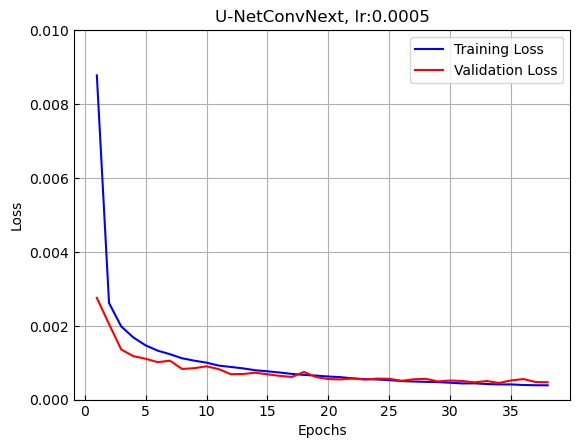

In [38]:
# Plotting the training and validation loss
plt.figure()
plt.title(f'U-NetConvNext, lr:{learning_rate}')
plt.plot(range(1, len(train_losses) + 1), train_losses,c='b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, c='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.01)
plt.tick_params(axis='both', direction='in')
plt.grid()
plt.legend()
plt.savefig("figures/U-Net_Loss.svg")
plt.show()

## Test

In [39]:
Bsize =20
stride =1
test_data = MyDataset("test")
print(len(test_data))
test_loader = torch.utils.data.DataLoader(dataset=test_data, shuffle=False, batch_size=Bsize, num_workers=0)

2002


In [40]:
# Test loop
test_vrmse = 0.0
field_vrmse = []
model.eval()
with torch.no_grad():
    for x, y in (bar := tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        batch_vrmse, field_eror = vrmse(pred, y, field_wise=True)
        test_vrmse += batch_vrmse
        field_vrmse.append(field_eror)

test_vrmse /= len(test_loader)
test_vrmse_field = torch.mean(torch.stack(field_vrmse, dim=0),dim=0)
test_vrmse_field = test_vrmse_field.cpu()

print(f"\nLearning rate {learning_rate}")
print(f"The test loss in VRMSE is: {test_vrmse:.6f}")
print(f"The test loss in VRMSE per field is: ", test_vrmse_field)


100%|██████████| 101/101 [00:30<00:00,  3.35it/s]


Learning rate 0.0005
The test loss in VRMSE is: 0.036670
The test loss in VRMSE per field is:  tensor([1.5276, 0.0680, 0.0627, 0.0442, 0.0377, 0.0375, 0.0435, 0.0664, 0.0644,
        0.0621, 0.0656])


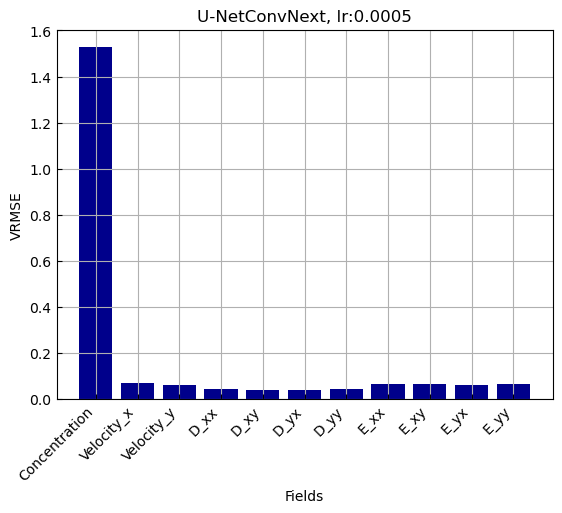

In [41]:
# Ploting VRMSE bar plot across 11 fields
field_names = ['Concentration', 'Velocity_x', 'Velocity_y', 'D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']
plt.figure()
plt.title(f'U-NetConvNext, lr:{learning_rate}')
plt.bar(field_names,test_vrmse_field, color='darkblue')
plt.xlabel('Fields')
plt.ylabel('VRMSE')
plt.tick_params(axis='both', direction='in')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.savefig("figures/U-net_RMSE_fiels-Net.svg")
plt.show()

# ConvLSTM

In [16]:
Bsize = 2
Stride = 20

training_data = MyDataset('train', stride = Stride)
print(len(training_data))
train_loader = torch.utils.data.DataLoader(dataset=training_data, shuffle=True, batch_size=Bsize, num_workers=0)

valid_data = MyDataset("valid", stride = Stride)
print(len(valid_data))
val_loader = torch.utils.data.DataLoader(dataset=valid_data, shuffle=False, batch_size=Bsize, num_workers=0)

175
24


In [17]:
from ConvLSTModule import Forecaster as ConvLSTModel

model_dir = "checkpoints/ConvLSTM/"

# Create folder if it does not exist
os.makedirs(model_dir, exist_ok=True)

In [18]:
# Training loop for various learning rates

raise KeyboardInterrupt # Comment this line if you want to start the trinning

# Training parameters
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
lr_values = [5e-3]
HH = [16, 32, 64, 128, 256]
patience = 5  # Early stopping patience

# learning_rate = lr_values[-1]
for learning_rate in lr_values:
    print(f'Model lr = {learning_rate}')
    checkpoint_dir = model_dir+str(learning_rate)+'-'+"-".join([str(num) for num in HH])

    model = ConvLSTModel(input_dim=11, hidden_dims=HH, kernel_size=(3, 3)) # test night
    # model = ConvLSTModel(input_dim=11, hidden_dims=[32, 64, 96, 96], kernel_size=(3, 3), num_layers=4)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if os.path.exists(checkpoint_dir) and bool(os.listdir(checkpoint_dir)):
        check_numbers = []
        for filename in os.listdir(checkpoint_dir):
            if filename.endswith('pt'):
                check_numbers.append(int(filename[-6:-3]))
        epoch0 = max(check_numbers)
        
        checkpoint = torch.load(checkpoint_dir+f"/epoch_{epoch0:03d}.pt")

        
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'epoch = {epoch0} loaded')
        epoch0 += 1


        train_losses = np.load(checkpoint_dir+'/train_losses.npy').tolist()
        val_losses = np.load(checkpoint_dir+'/val_losses.npy').tolist() 

        patience_counter = 0
        best_val_loss = min(val_losses)
        print(f'Best previous valitation loss = {best_val_loss}')
        val_i = -1
        if val_losses[val_i] == best_val_loss:
            patience_counter = 0  # Early stopping patience
        else:
            while val_losses[val_i] > best_val_loss:
                patience_counter += 1
                val_i-=1

    else:
        model = model.to(device)
        epoch0=1
        os.makedirs(checkpoint_dir, exist_ok=True)
        if not bool(os.listdir(checkpoint_dir)):
            print('Empty checkpoint directory')
        print(f'Starting at epoch = {epoch0}')
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

    print(f'Patience_counter = {patience_counter}')
    print('')

    for epoch in range(epoch0,101):
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch}:")
        
        model.train()
        train_loss = 0.0
        for x, y in (bar := tqdm(train_loader)):
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        print(f"Validation:")
        with torch.no_grad():
            for x, y in (bar := tqdm(val_loader)):
                x = x.to(device)
                y = y.to(device)

                # Forward pass
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Train loss = {train_loss}, Validation loss={val_loss}")

        torch.save({"epoch": epoch,"model_state_dict": model.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"loss": loss,}, checkpoint_dir+f"/epoch_{epoch:03d}.pt")
        np.save(checkpoint_dir+'/train_losses.npy', np.array(train_losses))
        np.save(checkpoint_dir+'/val_losses.npy', np.array(val_losses))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        print(f'Patience counter = {patience_counter}',end='\n\n')
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

KeyboardInterrupt: 

In [ ]:
# Loading the model
# Training parameters
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
lr_values = [5e-3]
HH = [16, 32, 64, 128, 256]
patience = 5  # Early stopping patience

# learning_rate = lr_values[-1]
for learning_rate in lr_values:
    print(f'Model lr = {learning_rate}')
    checkpoint_dir = model_dir+str(learning_rate)+'-'+"-".join([str(num) for num in HH])

    model = ConvLSTModel(input_dim=11, hidden_dims=HH, kernel_size=(3, 3)) # test night
    # model = ConvLSTModel(input_dim=11, hidden_dims=[32, 64, 96, 96], kernel_size=(3, 3), num_layers=4)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if os.path.exists(checkpoint_dir) and bool(os.listdir(checkpoint_dir)):
        check_numbers = []
        for filename in os.listdir(checkpoint_dir):
            if filename.endswith('pt'):
                check_numbers.append(int(filename[-6:-3]))
        epoch0 = max(check_numbers)
        
        checkpoint = torch.load(checkpoint_dir+f"/epoch_{epoch0:03d}.pt")

        
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'epoch = {epoch0} loaded')
        epoch0 += 1


        train_losses = np.load(checkpoint_dir+'/train_losses.npy').tolist()
        val_losses = np.load(checkpoint_dir+'/val_losses.npy').tolist() 

        patience_counter = 0
        best_val_loss = min(val_losses)
        print(f'Best previous valitation loss = {best_val_loss}')
        val_i = -1
        if val_losses[val_i] == best_val_loss:
            patience_counter = 0  # Early stopping patience
        else:
            while val_losses[val_i] > best_val_loss:
                patience_counter += 1
                val_i-=1

    else:
        model = model.to(device)
        epoch0=1
        os.makedirs(checkpoint_dir, exist_ok=True)
        if not bool(os.listdir(checkpoint_dir)):
            print('Empty checkpoint directory')
        print(f'Starting at epoch = {epoch0}')
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

    print(f'Patience_counter = {patience_counter}')
    print('')

Model lr = 0.005
epoch = 11 loaded
Best previous valitation loss = 0.12030456754608214
Patience_counter = 2



In [20]:
summary(model)

Layer (type:depth-idx)                   Param #
Forecaster                               --
├─ConvLSTM: 1-1                          --
│    └─ModuleList: 2-1                   --
│    │    └─ConvLSTMCell: 3-1            15,616
│    │    └─ConvLSTMCell: 3-2            55,424
│    │    └─ConvLSTMCell: 3-3            221,440
│    │    └─ConvLSTMCell: 3-4            885,248
│    │    └─ConvLSTMCell: 3-5            3,539,968
├─Conv2d: 1-2                            25,355
Total params: 4,743,051
Trainable params: 4,743,051
Non-trainable params: 0

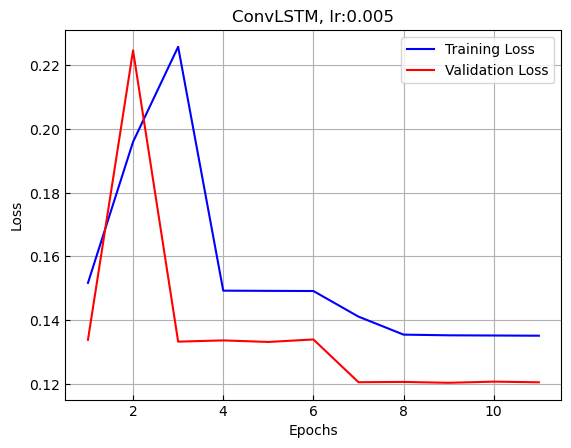

In [26]:
# Plotting the training and validation loss
plt.figure()
plt.title(f'ConvLSTM, lr:{learning_rate}')
plt.plot(range(1, len(train_losses) + 1), train_losses,c='b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, c='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tick_params(axis='both', direction='in')
plt.grid()
plt.legend()
plt.savefig("figures/ConvLSTM_Loss.svg")
plt.show()

## Test

In [23]:
Bsize = 3
stride = 1
test_data = MyDataset("test")
print(len(test_data))
test_loader = torch.utils.data.DataLoader(dataset=test_data, shuffle=False, batch_size=Bsize, num_workers=0)

2002


In [24]:
# Test loop
test_vrmse = 0.0
field_vrmse = []
model.eval()
with torch.no_grad():
    for x, y in (bar := tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        batch_vrmse, field_eror = vrmse(pred, y, field_wise=True)
        test_vrmse += batch_vrmse
        field_vrmse.append(field_eror)

test_vrmse /= len(test_loader)
test_vrmse_field = torch.mean(torch.stack(field_vrmse, dim=0),dim=0)
test_vrmse_field = test_vrmse_field.cpu()

print(f"\nLearning rate {learning_rate}")
print(f"The test loss in VRMSE is: {test_vrmse:.6f}")
print(f"The test loss in VRMSE per field is: ", test_vrmse_field)

100%|██████████| 668/668 [11:42<00:00,  1.05s/it]



Learning rate 0.005
The test loss in VRMSE is: 0.917217
The test loss in VRMSE per field is:  tensor([3.5811e+00, 1.4844e+03, 1.4790e+03, 2.4560e-01, 1.0347e+03, 1.0347e+03,
        2.4617e-01, 1.4825e+00, 1.2276e+03, 1.2276e+03, 1.3295e+00])


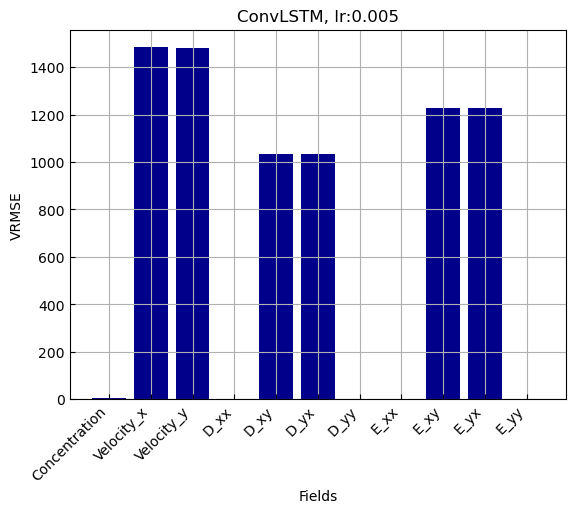

In [34]:
# Ploting VRMSE bar plot across 11 fields
field_names = ['Concentration', 'Velocity_x', 'Velocity_y', 'D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']
plt.figure()
plt.title(f'ConvLSTM, lr:{learning_rate}')
plt.bar(field_names,test_vrmse_field, color='darkblue')
plt.xlabel('Fields')
plt.ylabel('VRMSE')
plt.tick_params(axis='both', direction='in')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.savefig("figures/ConvLSTM_RMSE_fields.svg")
plt.show()

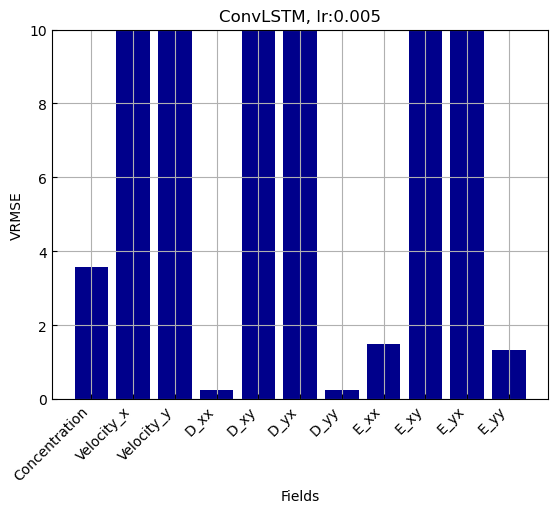

In [35]:
# Ploting VRMSE bar plot across 11 fields
field_names = ['Concentration', 'Velocity_x', 'Velocity_y', 'D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']
plt.figure()
plt.title(f'ConvLSTM, lr:{learning_rate}')
plt.bar(field_names,test_vrmse_field, color='darkblue')
plt.xlabel('Fields')
plt.ylabel('VRMSE')
plt.tick_params(axis='both', direction='in')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,10)
plt.grid()
plt.savefig("figures/ConvLSTM_RMSE_fields2.svg")
plt.show()